# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# # Google Colab trick to extend memory
# a = []
# while(1):
#     a.append('1')


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid


In [3]:
# Mount google drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
# Setting directories where data is stored and ouptut dir
if IN_COLAB:
    DATA_GRID_INPUT_DIR = './drive/My Drive/Colab Notebooks' 
    DATA_OUTPUT_DIR = './drive/My Drive/Colab Notebooks'
    !ls './drive/My Drive/Colab Notebooks'
else:
    DATA_GRID_INPUT_DIR = '.'
    DATA_OUTPUT_DIR = '.'

In [5]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [6]:
h = 28 # Prediction horizon
max_lags = 120 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


# 2. Feature Engineering

## Creating features


In [7]:
# data = data.loc[data.date > '2015-01-01'] 

In [8]:
# data

In [9]:
# dept_store_df = data[['id', 'date', 'item_id', 'dept_id', 'store_id', 'sales']].groupby(['dept_id', 'store_id', 'date'])['sales'].sum().reset_index()

In [10]:
# dept_store_df

In [11]:
# dept_store_df['dept_store_lag_3'] = dept_store_df.groupby(['dept_id', 'store_id'])['sales'].shift(28)
# dept_store_df['dept_sotre_rmean_3_3'] = dept_store_df.groupby(['dept_id', 'store_id'])['dept_store_lag_3'].transform(lambda x: x.rolling(3).mean())
# dept_store_df.drop(['sales'], axis=1, inplace=True)

In [12]:
# dept_store_df.loc[dept_store_df.date=='2016-04-23']

In [13]:
# data = data.merge(dept_store_df, on=['dept_id', 'store_id', 'date'], copy=False)

In [14]:
# data.loc[data.date=='2016-04-23']

In [15]:
# Init global variable to store columns of encodings
# To use them later for test dataset

# target_enc_cols = []

In [16]:
def create_features(df):

#     agg_levels = [['dept_id', 'store_id'],
#                   ['item_id']
#                   ]
#     agg_level_names = ['_'.join(level) for level in agg_levels]
    
#     # Create dataframes grouped by agg_levels and date
#     agg_df = dict()
#     for level, level_name in zip(agg_levels, agg_level_names):
#         agg_df[level_name] = df[['id', 'date', 'item_id', 'dept_id', 'store_id', 'sales']].groupby(level + ['date'])['sales'].sum().reset_index()

    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]
  
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
        
#         # Setting lags for agg levels
#         if lag in [1, 7, 28]:
#             for level, level_name in zip(agg_levels, agg_level_names):
#                 agg_df[level_name][level_name + '_' + lag_col] = agg_df[level_name].groupby(level)['sales'].shift(lag)

    wins = [7, 14, 28, 60]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)

            df[f"rmedian_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median()).astype(np.float16)
            # df[f"rdiff_mean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).diff().mean()).astype(np.float16)
            df[f"rstd_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype(np.float16)
            df[f'rmean_{lag}_{win}_decay'] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x: x.ewm(span=win).mean()).astype(np.float16)

#             # Computing rollings for aggregation levels
#             if (lag in [1, 7, 28]) and (win in [7, 28]):
#                 for level, level_name in zip(agg_levels, agg_level_names):
#                     agg_df[level_name][level_name + '_' + f'rmean_{lag}_{win}'] = agg_df[level_name].groupby(level)[level_name + '_' + lag_col].transform(lambda x: x.rolling(win).mean())
            
            

#     # Merging agg levels computations with main grid
#     for level, level_name in zip(agg_levels, agg_level_names):
#         agg_df[level_name].drop(['sales'], axis=1, inplace=True)
#         df = df.merge(agg_df[level_name], on=level + ['date'], copy=False)

    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
        
    
    # Adding mean/std target encoding features

    # Columns for to encode
#     icols =  [
#             ['state_id'],
#             ['store_id'],
#             ['cat_id'],
#             ['dept_id'],
#             ['state_id', 'cat_id'],
#             ['state_id', 'dept_id'],
#             ['store_id', 'cat_id'],
#             ['store_id', 'dept_id'],
#             ['item_id'],
#             ['item_id', 'state_id'],
#             ['item_id', 'store_id']
#             ]

#     global target_enc_cols 
    
#     for col in icols:
#         print('Encoding', col)
#         # TODO: Make this with variable, or may be use d column as integer
#         temp_df = df[df['date'] < datetime(2016, 3, 28)] # to be sure we don't have leakage in our validation set

#         temp_df = temp_df.groupby(col).agg({'sales': ['std','mean']})
#         col_name = '_enc_'+'_'.join(col)+'_'
#         new_columns = [col_name.join(col).strip() for col in temp_df.columns.values]
#         temp_df.columns = new_columns
#         temp_df = temp_df.reset_index()
#         #print(temp_df)
#         df = df.merge(temp_df, on=col, how='left')
#         #print(df)
#         # Save columns for later usage
#         target_enc_cols += new_columns
#         del temp_df
#         gc.collect()
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
            
    
    return df
    

In [17]:
%%time

data = create_features(data)

CPU times: user 37min 26s, sys: 2min 8s, total: 39min 35s
Wall time: 39min 45s


In [18]:
# Choose one day from data set, to have
# all encodings for every id for later merge 
# with test data

# mean_encodings_df = data.loc[data['d'] == 'd_1913', ['id'] + target_enc_cols].copy()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 95 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [20]:
data.dropna(inplace = True)
data.shape

(43375450, 95)

In [21]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t1,lag_t7,lag_t14,lag_t28,rmean_1_7,rmedian_1_7,rstd_1_7,rmean_1_7_decay,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_14_7,rmedian_14_7,rstd_14_7,rmean_14_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_1_14,rmedian_1_14,rstd_1_14,rmean_1_14_decay,rmean_7_14,rmedian_7_14,rstd_7_14,rmean_7_14_decay,rmean_14_14,rmedian_14_14,rstd_14_14,rmean_14_14_decay,rmean_28_14,rmedian_28_14,rstd_28_14,rmean_28_14_decay,rmean_1_28,rmedian_1_28,rstd_1_28,rmean_1_28_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_14_28,rmedian_14_28,rstd_14_28,rmean_14_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_1_60,rmedian_1_60,rstd_1_60,rmean_1_60_decay,rmean_7_60,rmedian_7_60,rstd_7_60,rmean_7_60_decay,rmean_14_60,rmedian_14_60,rstd_14_60,rmean_14_60_decay,rmean_28_60,rmedian_28_60,rstd_28_60,rmean_28_60_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
1112583,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_88,8.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,0.500000,10.0,5.0,6.0,0.0,9.000000,9.0,8.406250,8.187500,1.571289,0.0,2.699219,2.156250,5.714844,6.0,5.906250,4.792969,0.000000,0.0,5.960464e-08,0.029175,5.355469,2.5,7.132812e+00,6.550781,3.642578,0.0,4.910156,2.537109,4.429688,0.0,6.605469,4.167969,0.000000,0.0,0.000000,0.220581,4.679688,0.0,6.820312,5.007812,2.607422,0.0,5.136719,2.560547,2.214844,0.0,5.109375,3.212891,0.643066,0.0,2.376953,0.689453,2.482422,0.0,5.308594,3.806641,1.983398,0.0,4.132812,2.427734,2.017578,0.0,4.175781,2.675781,2.416016,0.0,4.417969,1.386719,0.434570,1.150391,17,2,26
1112584,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_89,1.0,2011-04-27,11113,6,5,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,8.0,23.0,6.0,0.0,9.429688,9.0,8.242188,8.140625,4.000000,0.0,8.585938,7.367188,4.714844,6.0,4.992188,5.093750,0.000000,0.0,5.960464e-08,0.021881,5.500000,2.5,7.164062e+00,6.742188,4.355469,0.0,6.753906,5.265625,4.855469,1.0,6.492188,4.414062,0.000000,0.0,0.000000,0.191162,4.964844,0.0,6.785156,5.214844,3.427734,0.0,6.390625,3.974609,2.427734,0.0,5.136719,3.406250,0.643066,0.0,2.376953,0.641113,2.617188,0.0,5.347656,3.951172,2.199219,0.0,4.839844,3.148438,1.966797,0.0,4.109375,2.794922,2.216797,0.0,4.246094,1.333984,0.436035,1.146484,17,2,27
1112585,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_90,0.0,2011-04-28,11113,4,6,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,6.285156,8.0,6.128906,6.355469,4.000000,0.0,8.585938,5.527344,2.857422,0.0,3.625000,3.820312,0.000000,0.0,5.960464e-08,0.016403,5.144531,0.5,7.261719e+00,5.976562,3.427734,0.0,6.359375,4.562500,4.855469,1.0,6.492188,3.826172,0.000000,0.0,0.000000,0.165649,5.000000,0.5,6.761719,4.921875,3.427734,0.0,6.390625,3.699219,2.427734,0.0,5.136719,3.169922,0.643066,0.0,2.376953,0.596680,2.632812,0.0,5.339844,3.849609,2.132812,0.0,4.839844,3.039062,1.916992,0.0,4.113281,2.695312,1.966797,0.0,3.910156,1.284180,0.437256,1.143555,17,2,28
1112586,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_91,0.0,2011-04-29,11113,0,7,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,6.285156,8.0,6.128906,4.765625,4.000000,0.0,8.585938,4.144531,2.857422,0.0,3.625000,2.865234,0.000000,0.0,5.960464e-08,0.012306,5.144531,0.5,7.261719e+00,5.179688,3.427734,0.0,6.359375,3.955078,4.855469,1.0,6.492188,3.314453,0.000000,0.0,0.000000,0.143555,5.000000,0.5,6.761719,4.582031,3.427734,0.0,6.390625,3.443359,2.427734,0.0,5.136719,2.951172,0.643066,0.0,2.376953,0.554688,2.632812,0.0,5.339844,3.716797,2.066406,0.0,4.843750,2.933594,1.916992,0.0,4.113281,2.599609,1.966797,0.0,3.910156,1.236328,0.438721,1.139648,17,2,29
1112590,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_88,0.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,1.769531,0.0,8.0,0.0,2.0,3.000000,2.0,3.873047,2.699219,3.142578,2.0,2.968750,3.613281,1.286133,2.0,1.253906,1.115234,0.714355,1.0,7.558594e-01,1.150391,2.50000

## Reduce mem usage of created features

In [22]:
data = reduce_mem_usage(data)

Mem. usage decreased to 8355.94 Mb (2.4% reduction)


In [23]:
gc.collect()

20

# 3. Fit & Predict

In [24]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 8.7618409 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t1,lag_t7,lag_t14,lag_t28,rmean_1_7,rmedian_1_7,rstd_1_7,rmean_1_7_decay,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_14_7,rmedian_14_7,rstd_14_7,rmean_14_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_1_14,rmedian_1_14,rstd_1_14,rmean_1_14_decay,rmean_7_14,rmedian_7_14,rstd_7_14,rmean_7_14_decay,rmean_14_14,rmedian_14_14,rstd_14_14,rmean_14_14_decay,rmean_28_14,rmedian_28_14,rstd_28_14,rmean_28_14_decay,rmean_1_28,rmedian_1_28,rstd_1_28,rmean_1_28_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_14_28,rmedian_14_28,rstd_14_28,rmean_14_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_1_60,rmedian_1_60,rstd_1_60,rmean_1_60_decay,rmean_7_60,rmedian_7_60,rstd_7_60,rmean_7_60_decay,rmean_14_60,rmedian_14_60,rstd_14_60,rmean_14_60_decay,rmean_28_60,rmedian_28_60,rstd_28_60,rmean_28_60_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
1112583,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_88,8.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,0.500000,10.0,5.0,6.0,0.0,9.000000,9.0,8.406250,8.187500,1.571289,0.0,2.699219,2.156250,5.714844,6.0,5.906250,4.792969,0.000000,0.0,5.960464e-08,0.029175,5.355469,2.5,7.132812,6.550781,3.642578,0.0,4.910156,2.537109,4.429688,0.0,6.605469,4.167969,0.000000,0.0,0.00000,0.220581,4.679688,0.0,6.820312,5.007812,2.607422,0.0,5.136719,2.560547,2.214844,0.0,5.109375,3.212891,0.643066,0.0,2.376953,0.689453,2.482422,0.0,5.308594,3.806641,1.983398,0.0,4.132812,2.427734,2.017578,0.0,4.175781,2.675781,2.416016,0.0,4.417969,1.386719,0.434570,1.150391,17,2,26
1112584,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_89,1.0,2011-04-27,11113,6,5,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,8.0,23.0,6.0,0.0,9.429688,9.0,8.242188,8.140625,4.000000,0.0,8.585938,7.367188,4.714844,6.0,4.992188,5.093750,0.000000,0.0,5.960464e-08,0.021881,5.500000,2.5,7.164062,6.742188,4.355469,0.0,6.753906,5.265625,4.855469,1.0,6.492188,4.414062,0.000000,0.0,0.00000,0.191162,4.964844,0.0,6.785156,5.214844,3.427734,0.0,6.390625,3.974609,2.427734,0.0,5.136719,3.406250,0.643066,0.0,2.376953,0.641113,2.617188,0.0,5.347656,3.951172,2.199219,0.0,4.839844,3.148438,1.966797,0.0,4.109375,2.794922,2.216797,0.0,4.246094,1.333984,0.436035,1.146484,17,2,27
1112585,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_90,0.0,2011-04-28,11113,4,6,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,6.285156,8.0,6.128906,6.355469,4.000000,0.0,8.585938,5.527344,2.857422,0.0,3.625000,3.820312,0.000000,0.0,5.960464e-08,0.016403,5.144531,0.5,7.261719,5.976562,3.427734,0.0,6.359375,4.562500,4.855469,1.0,6.492188,3.826172,0.000000,0.0,0.00000,0.165649,5.000000,0.5,6.761719,4.921875,3.427734,0.0,6.390625,3.699219,2.427734,0.0,5.136719,3.169922,0.643066,0.0,2.376953,0.596680,2.632812,0.0,5.339844,3.849609,2.132812,0.0,4.839844,3.039062,1.916992,0.0,4.113281,2.695312,1.966797,0.0,3.910156,1.284180,0.437256,1.143555,17,2,28
1112586,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_91,0.0,2011-04-29,11113,0,7,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,6.285156,8.0,6.128906,4.765625,4.000000,0.0,8.585938,4.144531,2.857422,0.0,3.625000,2.865234,0.000000,0.0,5.960464e-08,0.012306,5.144531,0.5,7.261719,5.179688,3.427734,0.0,6.359375,3.955078,4.855469,1.0,6.492188,3.314453,0.000000,0.0,0.00000,0.143555,5.000000,0.5,6.761719,4.582031,3.427734,0.0,6.390625,3.443359,2.427734,0.0,5.136719,2.951172,0.643066,0.0,2.376953,0.554688,2.632812,0.0,5.339844,3.716797,2.066406,0.0,4.843750,2.933594,1.916992,0.0,4.113281,2.599609,1.966797,0.0,3.910156,1.236328,0.438721,1.139648,17,2,29
1112590,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_88,0.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,1.769531,0.0,8.0,0.0,2.0,3.000000,2.0,3.873047,2.699219,3.142578,2.0,2.968750,3.613281,1.286133,2.0,1.253906,1.115234,0.714355,1.0,7.558594e-01,1.150391,2.500000,1.5,3.082031,2.515

In [25]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 27)

In [26]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"] + \
                ['lag_t1'] + ['dept_id_store_id_lag_t1', 'item_id_lag_t1'] # lag_t1 leads to overfitting
train_cols = data.columns[~data.columns.isin(useless_cols)]
#used_cols = train_cols.append(pd.Index(['weights'])) # with weights

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <=train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]

del data
gc.collect()

X_train_np = X_train.values.astype(np.float16)
X_valid_np = X_valid.values.astype(np.float16)

del X_train, X_valid
gc.collect()

train_data = lgb.Dataset(X_train_np, label = y_train, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid_np, label = y_valid, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
# train_data = lgb.Dataset(X_train[train_cols], label = y_train, weight=X_train['weights'], categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_valid[train_cols], label = y_valid, weight=X_valid['weights'], categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
# X_train = data[used_cols]
# y_train = data["sales"]

# np.random.seed(SEED)
# valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
# train_inds = np.setdiff1d(X_train.index.values, valid_inds)

# train_data = lgb.Dataset(X_train.loc[train_inds, train_cols] ,\
#                          label = y_train.loc[train_inds], weight=X_train.loc[train_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_train.loc[valid_inds, train_cols], \
#                          label = y_train.loc[valid_inds], weight=X_train.loc[valid_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# del valid_inds, train_inds

# del X_train, X_valid



CPU times: user 36.9 s, sys: 26.4 s, total: 1min 3s
Wall time: 1min 18s


In [27]:
params = {
#             'device' : 'gpu', # Need for local GPU computations
#             'max_bin': 31, # For better GPU performance
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'n_jobs': 4, # For local computation optimization
            'seed': SEED,
} 

# params = {
#         "objective" : "poisson",
#         "metric" :"rmse",
#         "force_row_wise" : True,
#         "learning_rate" : 0.075,
# #         "sub_feature" : 0.8,
#         "sub_row" : 0.8,
#         "bagging_freq" : 1,
#         'feature_fraction': 0.8,
#         "lambda_l2" : 0.1,
# #         "nthread" : 4
#         'verbosity': 1,
#         'num_iterations' : 1200,
#         'num_leaves': 2**7-1,
#         "min_data_in_leaf": 2**7-1,
#         'early_stopping_rounds': 125,
#         'seed': SEED,
# }

In [28]:
# # Trick to reduce memory spike while model starts training
# train_data.save_binary(f'{DATA_OUTPUT_DIR}/train.bin')
# valid_data.save_binary(f'{DATA_OUTPUT_DIR}/valid.bin')
# del train_data, valid_data
# gc.collect()
# train_data = lgb.Dataset(f'{DATA_OUTPUT_DIR}/train.bin', categorical_feature=cat_feats, two_round=True)
# valid_data = lgb.Dataset(f'{DATA_OUTPUT_DIR}/valid.bin', categorical_feature=cat_feats, two_round=True)

In [29]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.58384	valid_1's rmse: 2.10438
[100]	training's rmse: 2.30596	valid_1's rmse: 1.90933
[150]	training's rmse: 2.26382	valid_1's rmse: 1.88935
[200]	training's rmse: 2.23834	valid_1's rmse: 1.88045
[250]	training's rmse: 2.21861	valid_1's rmse: 1.87299
[300]	training's rmse: 2.20569	valid_1's rmse: 1.8671
[350]	training's rmse: 2.19573	valid_1's rmse: 1.86278
[400]	training's rmse: 2.18751	valid_1's rmse: 1.85894
[450]	training's rmse: 2.18052	valid_1's rmse: 1.8554
[500]	training's rmse: 2.17364	valid_1's rmse: 1.8517
[550]	training's rmse: 2.16699	valid_1's rmse: 1.84864
[600]	training's rmse: 2.16173	valid_1's rmse: 1.84605
[650]	training's rmse: 2.15653	valid_1's rmse: 1.84337
[700]	training's rmse: 2.15108	valid_1's rmse: 1.84032
[750]	training's rmse: 2.14567	valid_1's rmse: 1.83734
[800]	training's rmse: 2.14041	valid_1's rmse: 1.83446
[850]	training's rmse: 2.13591	valid_1's rmse: 1.83191
[900]	training's rmse: 2.13147	valid_1's rmse: 1.82893
[950]	training

In [30]:
os.system('say "Training complete"')

0

In [31]:
m_lgb.save_model(f'{DATA_OUTPUT_DIR}/model.lgb')
m_lgb = lgb.Booster(model_file=f'{DATA_OUTPUT_DIR}/model.lgb')

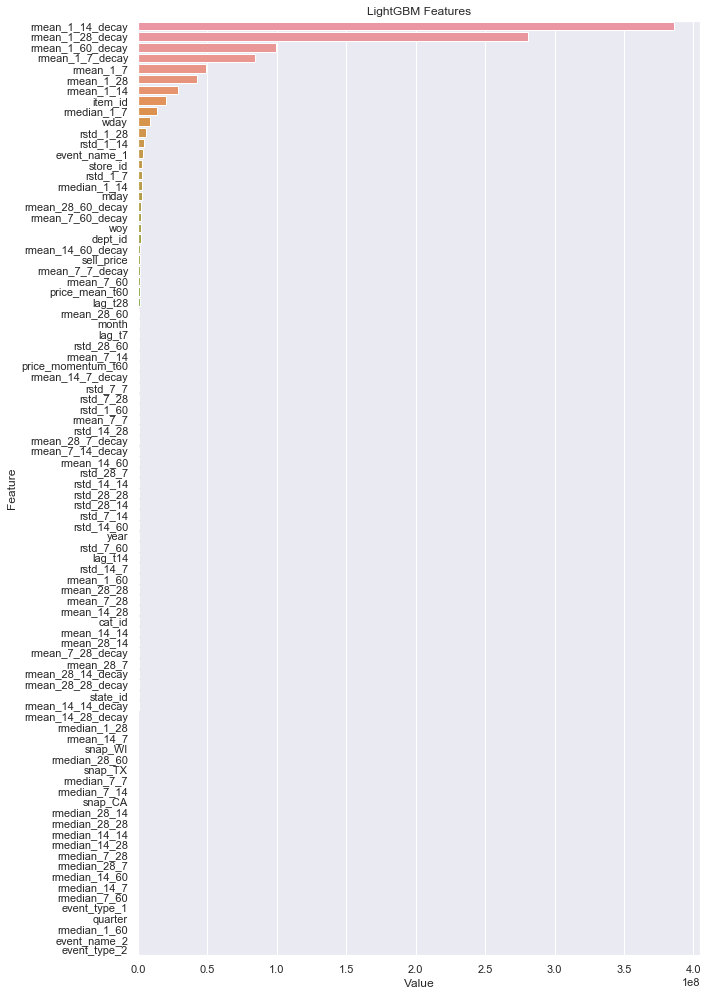

In [32]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [33]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
38,3.857016e+08,rmean_1_14_decay
54,2.807613e+08,rmean_1_28_decay
70,9.953682e+07,rmean_1_60_decay
22,8.411428e+07,rmean_1_7_decay
19,4.934657e+07,rmean_1_7
51,4.258389e+07,rmean_1_28
35,2.909194e+07,rmean_1_14
0,2.060088e+07,item_id
20,1.401694e+07,rmedian_1_7
5,8.564204e+06,wday


In [55]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 233 ms, sys: 180 ms, total: 413 ms
Wall time: 513 ms


In [56]:
def create_lag_features_for_test(df, day):
    
#     agg_levels = [['dept_id', 'store_id'],
#                   ['item_id']
#                   ]
#     agg_level_names = ['_'.join(level) for level in agg_levels]
    
#     # Create dataframes grouped by agg_levels and date
#     agg_df = dict()
#     for level, level_name in zip(agg_levels, agg_level_names):
#         agg_df[level_name] = df[['id', 'date', 'item_id', 'dept_id', 'store_id', 'sales']].groupby(level + ['date'])['sales'].sum().reset_index()
      
    # create lag feaures just for single day (faster)
    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main
        
#         # Setting lags for agg levels
#         if lag in [1, 7, 28]:
#             for level, level_name in zip(agg_levels, agg_level_names):
#                 agg_df[level_name][level_name + '_' + lag_col] = agg_df[level_name].groupby(level)['sales'].shift(lag)

    wins = [7, 14, 28, 60]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df_win = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+win))]
            df_win_grouped_mean = df_win.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{win}"] = df_win_grouped_mean.sales.values            

            df_win_grouped_median = df_win.groupby("id").agg({'sales':'median'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmedian_{lag}_{win}"] = df_win_grouped_median.sales.values
            df_win_grouped_std = df_win.groupby("id").agg({'sales':'std'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rstd_{lag}_{win}"] = df_win_grouped_std.sales.values

            df[f'rmean_{lag}_{win}_decay'] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x: x.ewm(span=win).mean()).astype(np.float16)
#             df[f"rmedian_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median()).astype(np.float16)
#             df[f"rstd_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype(np.float16)

#             # Computing rollings for aggregation levels
#             if (lag in [1, 7, 28]) and (win in [7, 28]):
#                 for level, level_name in zip(agg_levels, agg_level_names):
#                     agg_df[level_name][level_name + '_' + f'rmean_{lag}_{win}'] = agg_df[level_name].groupby(level)[level_name + '_' + lag_col].transform(lambda x: x.rolling(win).mean())


    
    
#     # Merging agg levels computations with main grid
#     for level, level_name in zip(agg_levels, agg_level_names):
#         agg_df[level_name].drop(['sales'], axis=1, inplace=True)
#         df = df.merge(agg_df[level_name], on=level + ['date'], copy=False)    

    return df
    
    
## Creating features for test data
def create_static_features_for_test(df):
    # We create lags here, so we can use them later 
    # for weighted moving average computations
    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
    
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    # Add mean encoding features
#     global mean_encodings_df
#     df = df.merge(mean_encodings_df, on=['id'])

    return df


In [57]:
tdata = create_static_features_for_test(tdata)

In [58]:
# # FOR TEST
# day = FIRST_PRED_DAY + timedelta(days=0)
# print(i, day)
# tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
# create_lag_features_for_test(tst, day)
# tst = tst.loc[tst.date == day, train_cols]


In [59]:
# os.system("say 'Task complete'")

In [60]:
# tst[tst.isna().any(axis=1)].shape[0] > 0

In [61]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    tst = create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    # Check that all features generated correctly
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
    tdata.loc[tdata.date == day, "sales"] = m_lgb.predict(tst.values.astype(np.float32)) # 1.035*


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 2h 30min 33s, sys: 8min 41s, total: 2h 39min 15s
Wall time: 2h 13min 20s


In [62]:
os.system('say "Prediction complete"')

0

In [63]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    148403
item_id               148403
dept_id               148403
store_id              148403
cat_id                148403
state_id              148403
d                     148403
sales                 148403
date                  148403
wm_yr_wk              148403
weekday               148403
wday                  148403
month                 148403
year                  148403
event_name_1          148403
event_type_1          148403
event_name_2          148403
event_type_2          148403
snap_CA               148403
snap_TX               148403
snap_WI               148403
sell_price            148403
lag_t1                  4391
lag_t7                 34218
lag_t14                72907
lag_t28               148403
woy                   148403
quarter               148403
mday                  148403
price_mean_t60        148403
price_momentum_t60    148403
dtype: int64

In [64]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# # kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.02

tdata_sub.to_csv(f"{DATA_OUTPUT_DIR}/submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.6 s, sys: 230 ms, total: 3.83 s
Wall time: 3.84 s


(60980, 29)

In [65]:
tst

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t14,lag_t28,rmean_1_7,rmedian_1_7,rstd_1_7,rmean_1_7_decay,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_14_7,rmedian_14_7,rstd_14_7,rmean_14_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_1_14,rmedian_1_14,rstd_1_14,rmean_1_14_decay,rmean_7_14,rmedian_7_14,rstd_7_14,rmean_7_14_decay,rmean_14_14,rmedian_14_14,rstd_14_14,rmean_14_14_decay,rmean_28_14,rmedian_28_14,rstd_28_14,rmean_28_14_decay,rmean_1_28,rmedian_1_28,rstd_1_28,rmean_1_28_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_14_28,rmedian_14_28,rstd_14_28,rmean_14_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_1_60,rmedian_1_60,rstd_1_60,rmean_1_60_decay,rmean_7_60,rmedian_7_60,rstd_7_60,rmean_7_60_decay,rmean_14_60,rmedian_14_60,rstd_14_60,rmean_14_60_decay,rmean_28_60,rmedian_28_60,rstd_28_60,rmean_28_60_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
4481422,0,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.216797,0.997070,1.0,0.944824,0.859863,0.174194,1.175781,0.955078,0.895020,0.174438,1.215820,0.923340,0.916504,0.164062,1.001953,1.142578,1.0,0.899902,1.070312,0.934082,0.884766,0.150024,1.162109,0.939453,0.897461,0.163452,1.178711,0.924316,0.879883,0.150269,1.036133,0.928711,1.0,0.997070,1.075195,0.929199,0.884766,0.147461,1.093750,0.986816,0.922852,0.454102,1.093750,0.926270,0.945312,0.699707,1.045898,0.964355,1.0,1.137695,1.054688,0.950195,0.908203,0.797852,1.037109,1.043945,1.000000,0.887695,1.036133,1.032227,1.000000,0.950684,1.023438,1.033203,1.0,1.088867,1.022461,8.351562,1.003906,20,2,22
4481429,1,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.313965,0.213745,0.0,0.241455,0.218262,0.055695,0.319824,0.216431,0.177490,0.059601,0.311768,0.209106,0.199585,0.023254,0.204834,0.142822,0.0,0.377930,0.079407,0.221802,0.208252,0.051453,0.288574,0.212769,0.197876,0.043640,0.252441,0.208496,0.197876,0.041168,0.149902,0.071411,0.0,0.267334,0.086853,0.207520,0.197876,0.061554,0.178101,0.194092,0.185059,0.185181,0.158569,0.140015,0.162598,0.200195,0.126831,0.071411,0.0,0.262207,0.110474,0.196777,0.168213,0.290527,0.163208,0.173950,0.000000,0.295898,0.160522,0.182007,0.000000,0.335693,0.154297,0.199951,0.0,0.403320,0.150146,3.970703,1.000000,20,2,22
4481436,2,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.835938,0.723145,1.0,0.608887,0.546875,0.136230,0.763672,0.606934,0.530762,0.149292,0.836914,0.554199,0.478760,0.121643,0.736816,0.856934,1.0,0.377930,0.931641,0.599609,0.539062,0.125732,0.778320,0.580566,0.525391,0.133667,0.846680,0.559570,0.496338,0.137329,0.799805,1.000000,1.0,0.679199,0.875977,0.589355,0.525391,0.151001,0.735352,0.645996,0.539062,0.248169,0.748535,0.779785,0.728027,0.530762,0.721680,0.571289,0.0,0.689941,0.721680,0.558594,0.512207,0.498047,0.592285,0.518066,0.479736,0.524414,0.589844,0.480469,0.449707,0.548828,0.578613,0.516602,0.0,0.947754,0.572266,2.970703,1.000000,20,2,22
4481443,3,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,4.640625,2.839844,2.419922,2.0,2.095703,1.867188,0.619629,3.111328,2.113281,1.898438,0.520508,2.839844,2.105469,1.873047,0.613770,2.449219,2.572266,2.0,2.369141,2.855469,2.074219,1.882812,0.517090,3.023438,2.109375,1.885742,0.546875,2.740234,2.037109,1.830078,0.667480,2.445312,2.072266,1.5,2.128906,2.470703,2.041016,1.860352,0.582031,2.505859,2.189453,1.863281,1.254883,2.365234,2.054688,1.830078,1.548828,2.250000,1.821289,1.0,1.886719,2.218750,2.101562,1.860352,1.602539,2.158203,2.156250,1.885742,1.647461,2.130859,2.025391,1.830078,1.721680,2.091797,1.916992,1.0,1.942383,2.068359,4.640625,1.000000,20,2,22
4481450,4,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.754883,1.263672,4.0,1.382812,1.196289,0.281250,1.807617,1.274414,1.152344,0.307129,1.758789,1.211914,1.150391,0.192749,1.323242,1.713867,2.0,1.253906,2.154297,1.293945,1.195312,0.261230,1.790039,1.243164,1.151367,0.248535,1.735352,1.175781,1.097656,0.